In [254]:
import math
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [255]:
def f(x):
    return 3*x**2 + 4*x + 5

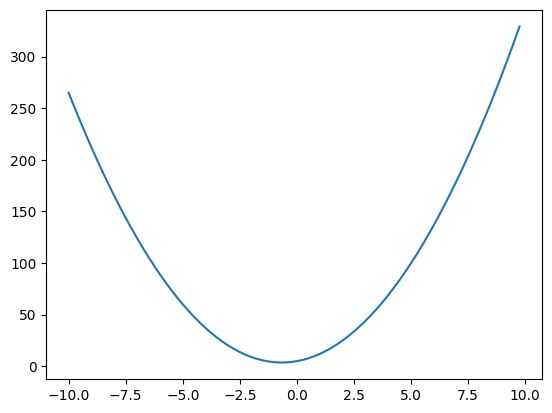

In [256]:
xs = np.arange(-10, 10, 0.25)
ys = f(xs)
plt.plot(xs, ys)

# Derivative
Devrivative of a function `f(x)` is a measure how sensitive it is to any change in `x`

Following is the definiation of a derivative

In [257]:
x = 3
h = 0.0001
slope = (f(x+h) - f(x)) / h
slope

22.000300000044604

In [258]:
h = 0.0001

# complex example
a = 2.0
b = -3.0
c = 10
d = a*b + c

# derivative of d wrt a
d1 = a*b + c
a += h
d2 = a*b + c
slop = (d2 - d1) / h
print(slop)



-3.000000000010772


# Let's build micrograd

In [308]:

from __future__ import annotations
from graphviz import Digraph
import math

class Value:
    def __init__(self, data, children=(), operation='', label=None):
        self.data = data
        self.grad = 0.0
        self.label = label

        # keep track of what contributed to this value
        self._prev = set(children)

        # what was the operation between the children to get this value
        self._operation = operation


        # keep track of the function to call to compute the gradient
        self._backward = lambda: None



    def __repr__(self):
        return f"Value({self.label},{self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)

        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            # why doing += ? 
            # because if the same variable contributes to multiple values and calling backwards multiple times overwrites the gradient, but we want to accumulate the gradient
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other
        
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def __neg__(self):
        return self * -1.0

    def __sub__(self, other):
        return self + (-other)

    def __truediv__(self, other):
        return self * other**-1

    def __pow__(self, other):
        assert isinstance(other, (int, float))

        x = self.data
        y = other
        out = Value(x**y, (self,), '**')

        def _backward():
            self.grad += y * x**(y-1) * out.grad
            # other.grad += x**y * math.log(x) * out.grad 

        out._backward = _backward
        return out

    def tanh(self):
        
        x = self.data
        t = ( math.exp(2*x) - 1 ) / ( math.exp(2*x) + 1 )
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        e = math.exp(x)
        out = Value(e, (self,), 'exp')

        def _backward():
            self.grad += e * out.grad

        out._backward = _backward
        return out

    def _trace(self):
        nodes, edges = set(), set()

        def _traverse(node):
            if node in nodes:
                return

            nodes.add(node)
            for prev in node._prev:
                edges.add((prev, node))
                _traverse(prev)

        _traverse(self)
        return nodes, edges

    def graph(self):
        dot = Digraph(format='svg',graph_attr={'rankdir':'LR'}) # LR = left to right
        nodes, edges = self._trace()

        for node in nodes:
            uid = str(id(node))
            # for value create a rectangle
            dot.node(uid, label=f"{node.label}| data: {node.data:.2f} | grad: {node.grad:.2f}",  shape='record')

            # create a node for the operation
            if node._operation:
                dot.node(name=uid + node._operation, label=node._operation)
                dot.edge(uid + node._operation, uid)

        for src, dst in edges:
            dot.edge(str(id(src)), str(id(dst)) + dst._operation)

        return dot

    def topological_sort(self) -> list[Value]:
        sorted_nodes = []
        visited = set()
        def _build_top(node):
            if node in visited:
                return

            if not isinstance(node, Value):
                return

            visited.add(node)
            for prev in node._prev:
                _build_top(prev)

            sorted_nodes.append(node)

        _build_top(self)
        return sorted_nodes

    def backward(self):
        # topological sort
        sorted_nodes = reversed(self.topological_sort())

        # start with the gradient of 1
        self.grad = 1.0

        # traverse the graph in reverse topological order
        for node in sorted_nodes:
            node._backward()
        



In [309]:

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10, label='c')

d = a*b + c; d.label = 'd'

f = Value(3, label='f')
L = d + f ; L.label = 'L'

# L.graph()

In [310]:
a = Value(2.0, label='a')
(a - 1) / (a + 1)

Value(None,0.3333333333333333)

In [311]:
# input
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

# cell body, withou activation
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1_x2w2 = x1w1 + x2w2; x1w1_x2w2.label = 'x1w1_x2w2'
n = x1w1_x2w2 + b; n.label = 'n'

# spelling out tanh
e = (n*2).exp(); e.label = 'e'
o = (e - 1)/(e + 1) ; o.label = 'o'




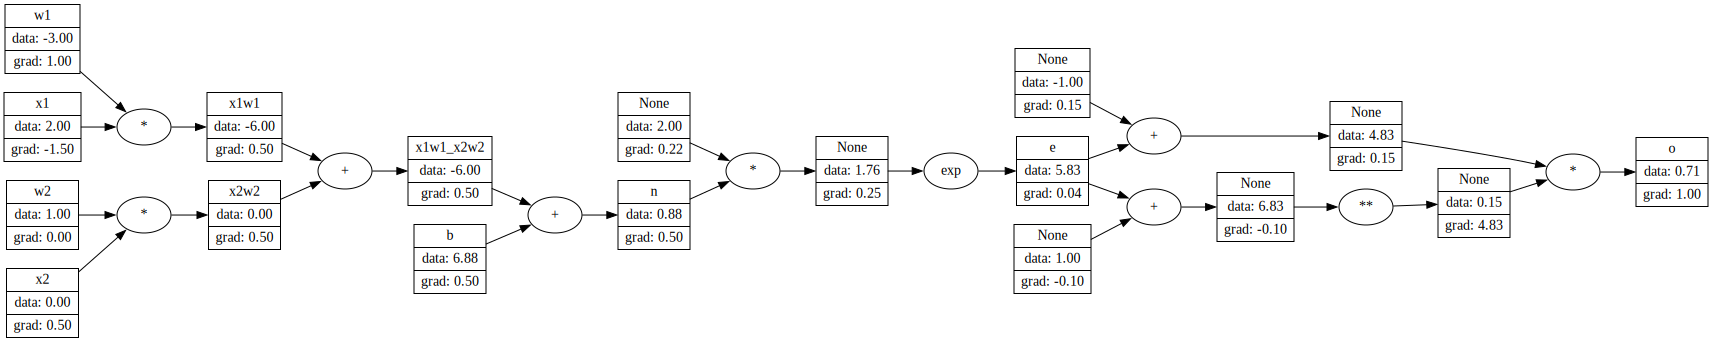

In [312]:
# We don't do this anymore, we use the backward method
# o.grad = 1.0
# o._backward()
# n._backward()
# x1w1_x2w2._backward()
# x1w1._backward()
# x2w2._backward()
o.backward()
o.graph()




In [313]:
# with pytorch, the same thing above
import torch

x1 = torch.tensor(2.0, requires_grad=True)
x2 = torch.tensor(0.0, requires_grad=True)
w1 = torch.tensor(-3.0, requires_grad=True)
w2 = torch.tensor(1.0, requires_grad=True)
b = torch.tensor(6.8813735870195432, requires_grad=True)
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)
o.backward()
print(o.item())
print(x1.grad, x2.grad, w1.grad, w2.grad, b.grad)

0.7071067094802856
tensor(-1.5000) tensor(0.5000) tensor(1.0000) tensor(0.) tensor(0.5000)


# Let's build NN


In [338]:
import random

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        act = self.b + sum(wi*xi for xi, wi in zip(x, self.w))
        return act.tanh()


    def parameters(self):
        return self.w + [self.b]


class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        return [neuron(x) for neuron in self.neurons]


    def parameters(self):
        params = []
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)

        return params


class MLP:
    def __init__(self, nin, nouts):
        sizes = [nin] + nouts
        self.layers = [Layer(sizes[i], sizes[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        params = []
        for layer in self.layers:
            ps = layer.parameters()
            params.extend(ps)

        return params


In [ ]:
def loss(y_pred, y_ground_truth):
    return sum((y_predi - y_ground_truthi)**2 for y_predi, y_ground_truthi in zip(y_pred, y_ground_truth))

def optimize(mlp : MLP, xs, ys, lr=0.01):
    pass


xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, -0.5],
    [0.5, 1.0, -1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

mlp = MLP(3, [4, 4, 1])

# Training loop
for k in range(1000):
    #forward pass
    ypred = [mlp(x)[0] for x in xs]

    # compute loss
    _loss = loss(ypred, ys)
    print(f"Step {k}:{_loss}")

    # zero gradients
    for p in mlp.parameters():
        p.grad = 0.0
    
    # backward pass
    _loss.backward()
    for p in mlp.parameters():
        p.data -= p.grad * 0.01


In [349]:
ypred


[Value(None,0.996993477467596),
 Value(None,-0.9643423333631543),
 Value(None,-0.9246532617704664),
 Value(None,0.9242557832869619)]